# Homework 1

## FINM 37400 - 2025

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

***

### Data

This homework uses the data file, `treasury_quotes_2024-10-31`.

The problems below analyze the nominal, (rather than the TIPS,) Treasury issues. Accordingly, you should filter out all rows with `type` `TIPS Note` or `TIPS bond`.

In [1]:
# PACKAGES
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.optimize import newton
from scipy.optimize import root_scalar
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from pyprojroot import here
import os 
import datetime
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

# SETTINGS
pd.set_option('display.float_format', '{:.4f}'.format) # Limiting floats output to 4 decimal points

# Set working directory
os.chdir("/Users/charleston/Downloads/git_repositories/finm-fixedincome-2025")
 
# DATE
quote_date = '2024-10-31'

# DATA
quotes = pd.read_excel(here(f"./data/treasury_quotes_{quote_date}.xlsx"), sheet_name="quotes", index_col=0)
# Remove TIPS
quotes.query('type != "TIPS bond" and type != "TIPS note"', inplace=True)

selected_quotes = pd.read_excel(here(f"./data/treasury_quotes_{quote_date}.xlsx"), sheet_name="selected quotes", index_col=0)
yields = pd.read_excel(here(f"./data/yields.xlsx"), sheet_name="yields", index_col=0)


# 1. Discount Rates

Use the data in the `selected quotes` tab.

Note:
* The selected treasuries are at nearly six-month intervals. 
* If you prefer, approximate that they mature at perfect 6-month intervals. 

### 1.1.

Create the cashflow matrix, $\textbf{C}$, where each rows is a Treasury issue, each column is a date, and each entry is the cash paid on a (normalized) face value of \$100.

In [2]:
def get_coupon_dates(quote_date,maturity_date):

    if isinstance(quote_date,str):
        quote_date = datetime.datetime.strptime(quote_date,'%Y-%m-%d')
        
    if isinstance(maturity_date,str):
        maturity_date = datetime.datetime.strptime(maturity_date,'%Y-%m-%d')
    
    # divide by 180 just to be safe
    temp = pd.date_range(end=maturity_date, periods=np.ceil((maturity_date-quote_date).days/180), freq=pd.DateOffset(months=6))
    # filter out if one date too many
    temp = pd.DataFrame(data=temp[temp > quote_date])

    out = temp[0]
    return out
    
def calc_cashflows(quote_data, coupon_payments = 2, face_value = 100):
    CF = pd.DataFrame(data=0, index=quote_data.index, columns=quote_data['maturity date'].unique())

    for i in quote_data.index:
        coupon_dates = get_coupon_dates(quote_data.loc[i, 'quote date'], quote_data.loc[i, 'maturity date'])

        if coupon_dates is not None:
            CF.loc[i, coupon_dates] = quote_data.loc[i, 'cpn rate'] / coupon_payments # It is assuming semi-annual coupon rate payments

        CF.loc[i, quote_data.loc[i, 'maturity date']] += face_value # On bond's maturity (final payment), add 100 to the cash flows. This assumes that the bond has a face value (par value) of 100. 
        

    CF = CF.fillna(0).sort_index(axis=1)
    CF.drop(columns=CF.columns[CF.sum() == 0], inplace=True)
    
    return CF

def calc_cashflows_approximation(quote_data, coupon_payments=2, face_value=100):
    df = quote_data.reset_index()
    C = pd.DataFrame(index=df['KYTREASNO'], columns=df['maturity date'])

    for idx, row in df.iterrows():
        kytreasno = row['KYTREASNO']
        maturity_date = row['maturity date']
        cpn_rate = row['cpn rate'] / coupon_payments  # Assuming semi-annual payments

        for date in df['maturity date']:
            if date < maturity_date:
                C.loc[kytreasno, date] = cpn_rate
            elif date == maturity_date:
                C.loc[kytreasno, date] = cpn_rate + face_value  # On maturity date, add the face value
            else:
                C.loc[kytreasno, date] = 0  # No payments after maturity
    return C


In [3]:
approx = True

if approx:
    CF = calc_cashflows_approximation(selected_quotes, coupon_payments = 2, face_value = 100)
else:  
    CF = calc_cashflows(selected_quotes, coupon_payments = 2, face_value = 100)
CF

maturity date,2025-04-30,2025-10-31,2026-04-30,2026-10-31,2027-04-30,2027-10-31,2028-04-30,2028-10-31,2029-04-30,2029-10-31,2030-04-30,2030-10-31,2031-04-30,2031-10-31
KYTREASNO,,,,,,,,,,,,,,
208042,101.9375,0,0,0,0,0,0,0,0,0,0,0,0,0
208129,2.5000,102.5000,0,0,0,0,0,0,0,0,0,0,0,0
208213,2.4375,2.4375,102.4375,0,0,0,0,0,0,0,0,0,0,0
208302,2.0625,2.0625,2.0625,102.0625,0,0,0,0,0,0,0,0,0,0
207875,1.3750,1.3750,1.3750,1.3750,101.3750,0,0,0,0,0,0,0,0,0
207960,2.0625,2.0625,2.0625,2.0625,2.0625,102.0625,0,0,0,0,0,0,0,0
208044,1.7500,1.7500,1.7500,1.7500,1.7500,1.7500,101.7500,0,0,0,0,0,0,0
208132,2.4375,2.4375,2.4375,2.4375,2.4375,2.4375,2.4375,102.4375,0,0,0,0,0,0
208216,2.3125,2.3125,2.3125,2.3125,2.3125,2.3125,2.3125,2.3125,102.3125,0,0,0,0,0


### 1.2.

Estimate the spot discount factors that rationalize the market prices of the treasuries. Do this via solving the linear system

$$\textbf{p} = {\textbf{C}}\, \textbf{z}$$

In [4]:
C_matrix = CF.values.astype(float)
p_vector = selected_quotes['price'].values
# Solve the linear system (C * z = p)
z, _, _, _ = np.linalg.lstsq(C_matrix, p_vector, rcond=None)

# Store the result as a pandas Series with the maturity dates as the index
spot_discount_factors = pd.Series(z, index=CF.columns)

spot_discount_factors

maturity date
2025-04-30   0.9782
2025-10-31   0.9581
2026-04-30   0.9394
2026-10-31   0.9211
2027-04-30   0.9030
2027-10-31   0.8849
2028-04-30   0.8663
2028-10-31   0.8481
2029-04-30   0.8311
2029-10-31   0.8145
2030-04-30   0.7963
2030-10-31   0.7790
2031-04-30   0.7620
2031-10-31   0.7464
dtype: float64

### 1.3.

Plot the time-to-maturity on the horizontal axis. On the vertical axis, plot the...
* discount factors

Make another plot, this time with the vertical axis displaying the
* semiannually compounded discount rates
* continuously compounded discount rates

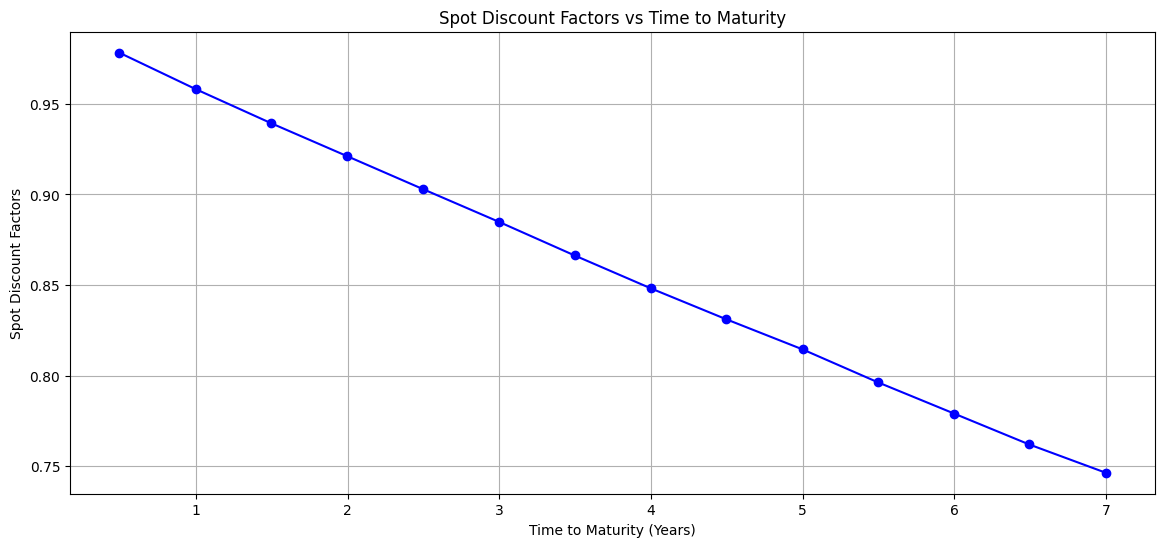

In [5]:
# Plotting the spot discount factors against time-to-maturity
plt.figure(figsize=(14, 6))
plt.plot(selected_quotes['ttm'], spot_discount_factors, marker='o', linestyle='-', color='b')
plt.xlabel('Time to Maturity (Years)')
plt.ylabel('Spot Discount Factors')
plt.title('Spot Discount Factors vs Time to Maturity')
plt.grid(True)
plt.show()

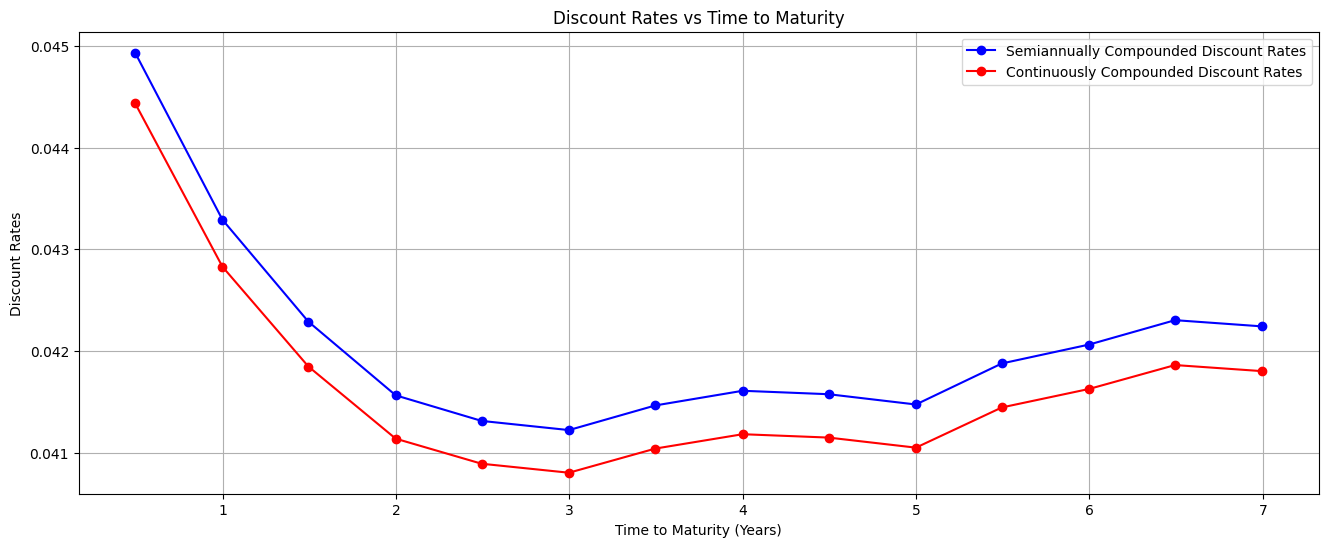

In [12]:
# Semiannually compounded discount rates
r_semiannual = 2 * ((1 / z)**(1 / (2 * selected_quotes['ttm'])) - 1)

# Continuously compounded discount rates
r_continuous = -np.log(z) / selected_quotes['ttm']

# Plot the semiannually and continuously compounded discount rates
plt.figure(figsize=(16, 6))

# Semiannually compounded discount rates
plt.plot(
    selected_quotes['ttm'],
    r_semiannual,
    marker='o',
    linestyle='-',
    color='b',
    label='Semiannually Compounded Discount Rates'
)
# Continuously compounded discount rates
plt.plot(
    selected_quotes['ttm'],
    r_continuous,
    marker='o',
    linestyle='-',
    color='r',
    label='Continuously Compounded Discount Rates'
)
plt.xlabel('Time to Maturity (Years)')
plt.ylabel('Discount Rates')
plt.title('Discount Rates vs Time to Maturity')
plt.legend()
plt.grid(True)
plt.show()

### 1.4.

Suppose that all discount rates and all coupon rates go up by 0.5\%. 

Calculate the new price of each of the treasury securities, using present value pricing.

In [31]:
new_discount_rates = r_semiannual + 0.005

df = selected_quotes.copy()
C = CF.copy()

for idx, row in df.iterrows():
    kytreasno = row.name
    maturity_date = row['maturity date']
    cpn_rate = row['cpn rate'] + 0.5 / 2

    for date in C.columns:
        if date < maturity_date:
            C.loc[kytreasno, date] = cpn_rate
        elif date == maturity_date:
            C.loc[kytreasno, date] = cpn_rate + 100
        else:
            C.loc[kytreasno, date] = 0

new_prices = []

# Iterate over each treasury (row in cashflow matrix)
for idx, row in C.iterrows():
    ttm = df.loc[idx, 'ttm']  # Time-to-maturity for the current treasury
    cashflows = row.values    # Cashflows for the current treasury
    
    # Adjusted discount factors using new_discount_rates
    discount_factors = [(1 + new_discount_rates.iloc[i]) ** (-ttm) for i in range(len(cashflows))]
    price = np.sum(cashflows * discount_factors)  # Calculate present value
    new_prices.append(price)

# Add new prices to the DataFrame
df['new_price'] = new_prices

# Display the updated DataFrame
df[['price', 'new_price']]


,price,new_price
KYTREASNO,,
208042,99.7174,101.6409
208129,100.6511,105.4052
208213,100.9453,107.6501
208302,99.9375,107.2391
207875,96.7656,102.6771
207960,100.0039,110.1756
208044,97.9219,107.6510
208132,102.6035,117.4332
208216,101.9121,117.1616


***

# 2. Estimating the Discount Curve with Real Data

Use the data in the `quotes` tab.

### 2.1. Map Cashflows

Construct the cashflow matrix.

Given the unfiltered data set, you will need to make a few modeling choices to do this...
* eliminate any treasury that does not report YTM or that reports a negative YTM.
* assume notes and bonds pay coupons every six months, going backward from the date of maturity.

Make other reasonable modeling assumptions as needed.

Report:
* head and tail rows of the dataframe, $\textbf{C}$, for instance, using `display()`.

* which date has the most cashflow across all issues?

* which date has the most issues paying a cashflow?

In [56]:
quotes.equals(quotes[quotes['ytm'] >= 0].dropna(subset=['ytm']))

approx = True
if approx:
    CF = calc_cashflows_approximation(quotes, coupon_payments = 2, face_value = 100)
else:  
    CF = calc_cashflows(quotes, coupon_payments = 2, face_value = 100)
display(CF)


maturity date,2024-11-05,2024-11-07,2024-11-12,2024-11-14,2024-11-15,2024-11-15,2024-11-15,2024-11-19,2024-11-21,2024-11-26,...,2052-05-15,2052-08-15,2052-11-15,2053-02-15,2053-05-15,2053-08-15,2053-11-15,2054-02-15,2054-05-15,2054-08-15
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
208246,100.0000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
208222,0.0000,100.0000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
208247,0.0000,0.0000,100.0000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
208223,0.0000,0.0000,0.0000,100.0000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
204083,3.7500,3.7500,3.7500,3.7500,103.7500,103.7500,103.7500,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208107,2.0625,2.0625,2.0625,2.0625,2.0625,2.0625,2.0625,2.0625,2.0625,2.0625,...,2.0625,2.0625,2.0625,2.0625,2.0625,102.0625,0,0,0,0
208149,2.3750,2.3750,2.3750,2.3750,2.3750,2.3750,2.3750,2.3750,2.3750,2.3750,...,2.3750,2.3750,2.3750,2.3750,2.3750,2.3750,102.3750,0,0,0
208178,2.1250,2.1250,2.1250,2.1250,2.1250,2.1250,2.1250,2.1250,2.1250,2.1250,...,2.1250,2.1250,2.1250,2.1250,2.1250,2.1250,2.1250,102.1250,0,0


In [57]:
print(f'The date with the most cashflow is {CF.sum().idxmax()}, with cashflows adding to {CF.sum().max()}')

The date with the most cashflow is 2024-12-31 00:00:00, with cashflows adding to 917.3125


In [58]:
print(f'The date with the most issues paying a cashflow is {CF.astype(bool).sum(axis=0).idxmax()}, with {CF.astype(bool).sum(axis=0).max()} issues paying a cashflow')

The date with the most issues paying a cashflow is 2024-11-05 00:00:00, with 345 issues paying a cashflow


### 2.2. OLS

Estimate the discount factors using OLS.

Starting with the cashflow matrix, $C$, create an additional filter to get a subset where every date has at least one maturity, (possibly multiple,) and every issue has its maturity in the cashflow matrix. Call this set of cashflows, $\hat{C}$.

**Report 5 head and tail rows of $\hat{C}$.**

$$\textbf{p} = \hat{\textbf{C}}\,\textbf{z}_{\text{ols}}+\epsilon$$

Plot the time-to-maturity vs discount rates, semiannually compounded.

In [61]:
# Check if all columns have at least one maturity
columns_with_maturity = CF.columns[(CF != 0).any(axis=0)]
all_columns_have_maturity = len(columns_with_maturity) == CF.shape[1]

# Check if every issue has its maturity in the cash flow matrix
issues_with_maturity = CF.index[(CF != 0).any(axis=1)]
all_issues_have_maturity = len(issues_with_maturity) == CF.shape[0]

print(f"All columns have at least one maturity: {all_columns_have_maturity}")
print(f"All issues have their maturity in the cash flow matrix: {all_issues_have_maturity}")

All columns have at least one maturity: True
All issues have their maturity in the cash flow matrix: True


In [63]:
display(CF)

maturity date,2024-11-05,2024-11-07,2024-11-12,2024-11-14,2024-11-15,2024-11-15,2024-11-15,2024-11-19,2024-11-21,2024-11-26,...,2052-05-15,2052-08-15,2052-11-15,2053-02-15,2053-05-15,2053-08-15,2053-11-15,2054-02-15,2054-05-15,2054-08-15
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
208246,100.0000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
208222,0.0000,100.0000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
208247,0.0000,0.0000,100.0000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
208223,0.0000,0.0000,0.0000,100.0000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
204083,3.7500,3.7500,3.7500,3.7500,103.7500,103.7500,103.7500,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208107,2.0625,2.0625,2.0625,2.0625,2.0625,2.0625,2.0625,2.0625,2.0625,2.0625,...,2.0625,2.0625,2.0625,2.0625,2.0625,102.0625,0,0,0,0
208149,2.3750,2.3750,2.3750,2.3750,2.3750,2.3750,2.3750,2.3750,2.3750,2.3750,...,2.3750,2.3750,2.3750,2.3750,2.3750,2.3750,102.3750,0,0,0
208178,2.1250,2.1250,2.1250,2.1250,2.1250,2.1250,2.1250,2.1250,2.1250,2.1250,...,2.1250,2.1250,2.1250,2.1250,2.1250,2.1250,2.1250,102.1250,0,0


In [70]:
# Define the dependent variable Y and independent variable X
Y = quotes['price']
X = CF

# Initialize the Linear Regression model without intercept
model = LinearRegression(fit_intercept=False)

# Fit the model
model.fit(X, Y)

# Get the coefficients
coefficients = model.coef_

coefficients


array([ 7.56248854e-01,  6.18196834e-01,  3.53485112e-01,  4.22536910e-01,
       -1.45822797e+14, -4.79144429e+13,  1.93737240e+14,  1.71206165e-01,
        8.31386802e-01,  2.37940636e-01,  9.08040180e-01, -1.70241459e+14,
       -2.01395476e+13,  1.90381006e+14,  1.01364924e+00,  7.25285662e-01,
        9.42960836e-01,  8.31475211e-01,  7.25825921e-01,  7.53200172e-01,
        1.43587375e+00,  9.36175344e-01,  7.88592998e-01, -3.07418862e+14,
        2.71641139e+14, -4.31107952e+13,  7.88885184e+13,  5.47047049e-01,
        7.52726793e-01,  4.94262695e-01,  7.89096832e-01,  5.56770325e-01,
        3.67675781e-01,  7.34375000e-01,  1.13281250e+00,  4.80468750e-01,
        5.50781250e-01, -3.79440717e+13,  4.34183168e+13, -5.47424511e+12,
        1.10546875e+00,  9.06250000e-01,  9.88281250e-01,  7.03125000e-01,
        1.00574478e+14, -1.68835114e+14,  6.82606361e+13,  1.15625000e+00,
        9.10156250e-01,  4.57031250e-01,  1.15234375e+00,  4.36914579e+13,
        1.14786225e+14, -

### 2.3. EXTRA (not graded)

Re-do `2.2.`, but this time use Weighted Least Squares. Find a weighting scheme that puts more weight on more recently issued treasures and less weight on less recently issued treasures. 

Does your answer change much?


### 2.4. Curve-Fitting

Continue with the model of cashflows (having filtered out some treasuries).

Estimate the discount curve via the Nelson-Siegel model.
* Fit via minimizing the sum of squared errors of the modeled prices against the quoted prices.
* Consider using `minimize` from `scipy.optimize`.

When done,
* Report the estimated NS parameters.
* Plot the semiannually-compounded discount rates along with those estimated with OLS from above.

***

# 3. Yield-Curve Factors

### Data
This section uses data in `'../data/yields.xlsx`.



### 3.1. Yield Curve Movements

Use the yield curve time-series data to calculate the time-series of the **level**, **slope**, and **curvature** factors.

Calculate the yield-curve factors. For each point in time, calculate the following three factors:

$\begin{align}
x^{\text{level}}_t =& \frac{1}{N_{\text{yields}}}\sum_{i=1}^{N_{\text{yields}}} y^{(i)}_t\\
x^{\text{slope}}_t =& y^{(30)}_t - y^{(1)}_t\\
x^{\text{curvature}}_t =& -y^{(1)}_t + 2 y^{(10)}_t - y^{(30)}_t
\end{align}$

Report the 
* correlation matrix of the factors.
* *mean and volatility of the factors.

### 3.2. PCA

Calculate the principal components of the time-series yield data.

Report...
* the percentage of total variation explained by each factor.
* the loadings of the first two PCA factors.

#### Note
Consider using,
`PCA` from `sklearn.decomposition` 

### 3.3. Comparison

Compare the ad-hoc factors from `3.1.` with the PCA-estimated factors in `3.2.`.

Estimate the correlation of the ad-hoc level factor with the PCA-1. And the slope factor with PCA-2.